# Introduction

Pada Project ini, saya berperan sebagai anggota dari tim Data Scientist di sebuah perusahaan start-up teknologi. Perusahaan saat ini sedang dilanda masalah besar, banyak karyawan yang mengajukan pengunduran diri namun perusahaan belum mengambil keputusan untuk hal itu. Saya diminta untuk membantu perusahaan untuk menjelaskan kondisi karyawannya saat ini, serta menelusuri permasalahan yang ada dalam perusahaan yang menyebabkan karyawan itu resign sehingga dapat mengurangi tingkat resign dari karyawan, dan dapat menjabarkan suatu strategi yang dapat meningkatkan retensi dari karyawan. Saya diminta untuk menyajikan temuan deskriptif dari data menggunakan data visualisasi dan data storytelling.

# 0. Initialization

In [78]:
import shap
import math
import numpy as np
import pandas as pd
import seaborn as sns
# import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [79]:
# pio.renderers.default = 'notebook'
# pio.renderers.default = 'browser'

In [80]:
df = pd.read_csv('../data/Improving Employee Retention by Predicting Employee Attrition Using Machine.csv', sep=',')
df.head()

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,...,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,...,+6282232522xxx,spiritedPorpoise3135@yahoo.com,Magister,1,1.0,masih_bekerja,1972-07-01,2011-01-10,2016-2-15,-
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,...,+6281270745xxx,jealousGelding2239@yahoo.com,Sarjana,1,1.0,toxic_culture,1984-04-26,2014-01-06,2020-1-17,2018-6-16
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,...,+6281346215xxx,pluckyMuesli3961@icloud.com,Magister,1,1.0,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-9-24
3,stressedTruffle1,106325,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,...,+6283233846xxx,stressedTruffle1406@hotmail.com,Sarjana,1,0.0,masih_bekerja,1979-11-24,2014-2-17,2020-02-04,-
4,shyTermite7,111171,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,...,+6287883263xxx,shyTermite7149@gmail.com,Sarjana,1,0.0,ganti_karir,1974-11-07,2013-11-11,2020-1-22,2018-09-06


# 1. Data Preprocessing

## 1.1 Quick EDA

In [81]:
# Informasi dataset
print("Info Dataset:")
print(f"Jumlah baris : {df.shape[0]}")
print(f"Jumlah kolom : {df.shape[1]}")

Info Dataset:
Jumlah baris : 287
Jumlah kolom : 25


In [82]:
# Informasi kolom
print("Info Kolom:")
print(df.info())

Info Kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Username                            287 non-null    object 
 1   EnterpriseID                        287 non-null    int64  
 2   StatusPernikahan                    287 non-null    object 
 3   JenisKelamin                        287 non-null    object 
 4   StatusKepegawaian                   287 non-null    object 
 5   Pekerjaan                           287 non-null    object 
 6   JenjangKarir                        287 non-null    object 
 7   PerformancePegawai                  287 non-null    object 
 8   AsalDaerah                          287 non-null    object 
 9   HiringPlatform                      287 non-null    object 
 10  SkorSurveyEngagement                287 non-null    int64  
 11  SkorKepuasanPegawai              

In [83]:
numerical_features = ['EnterpriseID', 'SkorSurveyEngagement', 'SkorKepuasanPegawai', 
                      'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir',
                      'JumlahKetidakhadiran', 'IkutProgramLOP'
                      ]

# categorical_features = df.select_dtypes(include=[object])
categorical_features = ['StatusPernikahan', 'JenisKelamin', 'StatusKepegawaian', 'Pekerjaan', 
                        'JenjangKarir', 'PerformancePegawai', 'AsalDaerah', 'HiringPlatform',
                        'TingkatPendidikan', 'PernahBekerja', 'AlasanResign'
                        ]

In [84]:
# Statistical summaries feature numerical
df[numerical_features].describe()

,EnterpriseID,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,IkutProgramLOP
count,287.000000,287.000000,282.000000,284.000000,286.000000,281.000000,29.000000
mean,105923.324042,3.101045,3.904255,1.179577,0.412587,10.448399,0.517241
std,4044.977599,0.836388,0.913355,2.294441,1.275016,6.902252,0.508548
min,100282.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,101269.000000,3.000000,3.000000,0.000000,0.000000,5.000000,0.000000
50%,106069.000000,3.000000,4.000000,0.000000,0.000000,10.000000,1.000000
75%,110514.500000,4.000000,5.000000,0.000000,0.000000,15.000000,1.000000
max,111703.000000,5.000000,5.000000,8.000000,6.000000,55.000000,1.000000


In [85]:
# Statistical summaries feature categorical
df[categorical_features].describe()

,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,TingkatPendidikan,PernahBekerja,AlasanResign
count,287,287,287,287,287,287,287,287,287,287,221
unique,5,2,3,14,3,5,5,9,3,2,11
top,Belum_menikah,Wanita,FullTime,Software Engineer (Back End),Freshgraduate_program,Biasa,Jakarta Pusat,Indeed,Sarjana,1,masih_bekerja
freq,132,167,217,109,169,85,72,85,176,286,132


In [86]:
# Pengecekan data yang hilang
print("\nPengecekan Missing Values:")
df.isnull().sum()


Pengecekan Missing Values:


Username                                0
EnterpriseID                            0
StatusPernikahan                        0
JenisKelamin                            0
StatusKepegawaian                       0
Pekerjaan                               0
JenjangKarir                            0
PerformancePegawai                      0
AsalDaerah                              0
HiringPlatform                          0
SkorSurveyEngagement                    0
SkorKepuasanPegawai                     5
JumlahKeikutsertaanProjek               3
JumlahKeterlambatanSebulanTerakhir      1
JumlahKetidakhadiran                    6
NomorHP                                 0
Email                                   0
TingkatPendidikan                       0
PernahBekerja                           0
IkutProgramLOP                        258
AlasanResign                           66
TanggalLahir                            0
TanggalHiring                           0
TanggalPenilaianKaryawan          

- Pada kolom 'SkorKepuasanPegawai' terdapat 5 data yang missing value. 
- Pada kolom 'JumlahKeikutsertaanProjek' terdapat 3 data yang missing value. 
- Pada kolom 'JumlahKeterlambatanSebulanTerakhir' terdapat 1 data yang missing value. 
- Pada kolom 'JumlahKetidakhadiran' terdapat 6 data yang missing value. 
- Pada kolom 'IkutProgramLOP' terdapat 258 data yang missing value.
- Pada kolom 'AlasanResign' terdapat 66 data yang missing value.

In [87]:
# Pengecekan data yang duplicate
print("\nPengecekan Data Duplicate:")
df.duplicated().value_counts()


Pengecekan Data Duplicate:


False    287
Name: count, dtype: int64

- Tidak ada data yang duplicate.

In [88]:
# Pengecekan jumlah unique value untuk kolom categorical
for col in categorical_features:
    unique = len(df[col].unique())
    print(f"{col} : {unique}")

StatusPernikahan : 5
JenisKelamin : 2
StatusKepegawaian : 3
Pekerjaan : 14
JenjangKarir : 3
PerformancePegawai : 5
AsalDaerah : 5
HiringPlatform : 9
TingkatPendidikan : 3
PernahBekerja : 2
AlasanResign : 12


In [89]:
# Pengecekan kolom 'PernahBekerja'
result = df['PernahBekerja'].unique()
result

array(['1', 'yes'], dtype=object)

- Fitur PernahBekerja adalah fitur yang hanya memiliki satu unique value.

In [90]:
result = df.loc[df['IkutProgramLOP'].isna()]
result[['Username', 'EnterpriseID', 'Pekerjaan', 'SkorKepuasanPegawai', 'PernahBekerja', 'IkutProgramLOP', 'AlasanResign']]
# result

,Username,EnterpriseID,Pekerjaan,SkorKepuasanPegawai,PernahBekerja,IkutProgramLOP,AlasanResign
6,madZebra1,100309,Data Analyst,3.0,1,NaN,masih_bekerja
7,cynicalMandrill7,110500,Software Engineer (Back End),5.0,1,NaN,masih_bekerja
8,lyingMussel8,110533,Software Engineer (Android),NaN,1,NaN,masih_bekerja
9,enviousMoth4,110927,Software Engineer (Android),5.0,1,NaN,masih_bekerja
11,grizzledSnipe7,111354,Software Engineer (Back End),5.0,1,NaN,tidak_bahagia
...,...,...,...,...,...,...,...
280,anxiousTeal2,111378,Software Engineer (Back End),5.0,1,NaN,NaN
281,anxiousWasp6,100628,Software Engineer (Front End),5.0,1,NaN,NaN
282,dopeySheep0,106034,Data Engineer,5.0,1,NaN,NaN
283,yearningPorpoise4,106254,Product Design (UI & UX),5.0,1,NaN,jam_kerja


## 1.2 Handling Missing Value

In [91]:
df_clean = df.copy()

In [92]:
# Pengecekan data yang hilang
print("\nPengecekan Missing Values:")
df.isnull().sum()


Pengecekan Missing Values:


Username                                0
EnterpriseID                            0
StatusPernikahan                        0
JenisKelamin                            0
StatusKepegawaian                       0
Pekerjaan                               0
JenjangKarir                            0
PerformancePegawai                      0
AsalDaerah                              0
HiringPlatform                          0
SkorSurveyEngagement                    0
SkorKepuasanPegawai                     5
JumlahKeikutsertaanProjek               3
JumlahKeterlambatanSebulanTerakhir      1
JumlahKetidakhadiran                    6
NomorHP                                 0
Email                                   0
TingkatPendidikan                       0
PernahBekerja                           0
IkutProgramLOP                        258
AlasanResign                           66
TanggalLahir                            0
TanggalHiring                           0
TanggalPenilaianKaryawan          

In [93]:
result = df.loc[df['AlasanResign'].isna()]
result[['TanggalResign', 'AlasanResign']]
# result

,TanggalResign,AlasanResign
105,-,NaN
187,-,NaN
189,-,NaN
190,-,NaN
195,-,NaN
...,...,...
279,-,NaN
280,-,NaN
281,-,NaN
282,-,NaN


In [94]:
result = df.loc[df['SkorKepuasanPegawai'].isna()]
result[['Username', 'EnterpriseID', 'SkorKepuasanPegawai','Pekerjaan']]

,Username,EnterpriseID,SkorKepuasanPegawai,Pekerjaan
8,lyingMussel8,110533,NaN,Software Engineer (Android)
25,needySyrup4,101226,NaN,Product Manager
55,importedApricots7,105820,NaN,Software Engineer (Back End)
122,puzzledBurritos7,111373,NaN,Software Engineer (Android)
166,resolvedCod5,110380,NaN,Product Design (UI & UX)


In [95]:
# Mengisi nilai null pada Kolom 'SkorKepuasanPegawai' dengan Modus
df_clean['SkorKepuasanPegawai'].fillna(df_clean['SkorKepuasanPegawai'].mode()[0], inplace=True)

# Mengisi nilai null pada Kolom 'JumlahKeikutsertaanProjek' dengan Modus
df_clean['JumlahKeikutsertaanProjek'].fillna(df_clean['JumlahKeikutsertaanProjek'].mode()[0], inplace=True)

# Mengisi nilai null pada Kolom 'JumlahKeterlambatanSebulanTerakhir' dengan Modus
df_clean['JumlahKeterlambatanSebulanTerakhir'].fillna(df_clean['JumlahKeterlambatanSebulanTerakhir'].mode()[0], inplace=True)

# Mengisi nilai null pada Kolom 'JumlahKetidakhadiran' dengan Modus
df_clean['JumlahKetidakhadiran'].fillna(df_clean['JumlahKetidakhadiran'].mode()[0], inplace=True)

# Mengisi nilai null pada Kolom 'AlasanResign' dengan 'masih_bekerja'
df_clean['AlasanResign'].fillna('masih_bekerja', inplace=True)

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\2519136392.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\2519136392.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

- Melakukan handling missing value pada fitur SkorKepuasanPegawai, JumlahKeikutsertaanProjek, JumlahKeterlambatanSebulanTerakhir, dan JumlahKetidakhadiran dengan mengisinya menggunakan modus.

- Melakukan handling missing value pada fitur AlasanResign dengan mengisi nilainya menjadi masih_bekerja karena pada fitur TanggalResign masih kosong (belum ada tanggalnya).

In [96]:
result = df_clean.loc[df_clean['AlasanResign'].isna()]
result[['Username', 'EnterpriseID', 'SkorKepuasanPegawai','Pekerjaan']]

,Username,EnterpriseID,SkorKepuasanPegawai,Pekerjaan


## 1.3 Drop Features

In [97]:
# Menghapus Fitur yang Tidak Diperlukan
drop_features = ['Username', 'EnterpriseID', 'PernahBekerja', 'IkutProgramLOP']

# df.drop(drop_features, axis=1, inplace=True)
df_clean = df_clean.drop(drop_features, axis=1, inplace=False)
print(f"Jumlah kolom setelah drop features : {df_clean.shape[1]}")

Jumlah kolom setelah drop features : 21


- Fitur-fitur yang dihapus yakni fitur-fitur yang tidak diperlukan dan fitur yang terlalu banyak missing valuenya seperti 'Username', 'EnterpriseID', 'PernahBekerja', dan 'IkutProgramLOP'.

# 2. Annual Report on Employee Number Changes

## 2.1 Aggregate Table

In [98]:
df_report = df_clean.copy()

In [99]:
# Membuat tabel agregat jumlah karyawan yang masuk dan keluar berdasarkan tahun hiring dan resign
df_report['TahunHiring'] = pd.to_datetime(df_report['TanggalHiring'], format='%Y-%m-%d', errors='coerce').dt.year
df_report['TahunResign'] = pd.to_datetime(df_report['TanggalResign'], format='%Y-%m-%d', errors='coerce').dt.year

In [100]:
# Agregat jumlah karyawan yang masuk per tahun (berdasarkan TahunHiring)
hire_count = df_report.groupby('TahunHiring').size().reset_index(name='JumlahKaryawanMasuk')

In [101]:
# Agregat jumlah karyawan yang keluar per tahun (berdasarkan TahunResign)
resign_count = df_report.groupby('TahunResign').size().reset_index(name='JumlahKaryawanKeluar')

## 2.2 Join Table

In [102]:
# Join dua tabel tersebut berdasarkan tahun
merged_df = pd.merge(hire_count, resign_count, left_on='TahunHiring', right_on='TahunResign', how='outer', suffixes=('_Hire', '_Resign'))

## 2.3 Imputation Missing Values

In [103]:
# Melakukan imputation pada data tahun yang kosong (fillna dengan 0 untuk yang tidak ada)
merged_df['JumlahKaryawanMasuk'].fillna(0, inplace=True)
merged_df['JumlahKaryawanKeluar'].fillna(0, inplace=True)

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\932283920.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\932283920.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [104]:
# Menyusun tabel sehingga semua data berurut sesuai tahun
merged_df['Tahun'] = merged_df['TahunHiring'].combine_first(merged_df['TahunResign']).astype(int)
merged_df.sort_values('Tahun', inplace=True)

## 2.4 Calculate Total Employees by Status

In [105]:
# Menghitung total karyawan yang resign, yang masih bertahan, dan perubahan setiap tahunnya
merged_df['TotalKaryawan'] = merged_df['JumlahKaryawanMasuk'].cumsum() - merged_df['JumlahKaryawanKeluar'].cumsum()
merged_df['PerubahanKaryawan'] = merged_df['JumlahKaryawanMasuk'] - merged_df['JumlahKaryawanKeluar']

## 2.5 Visualization of Changes in The Number of Employees 

In [106]:
# Plot perubahan kenaikan dan penurunan jumlah karyawan setiap tahun
fig = go.Figure(go.Waterfall(
    name="Perubahan Karyawan", orientation="v",
    measure=["relative"] * len(merged_df),
    x=merged_df['Tahun'],
    y=merged_df['PerubahanKaryawan'],
    text=merged_df['PerubahanKaryawan'],
    connector={"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
    title="Waterfall Chart Perubahan Jumlah Karyawan Tiap Tahun",
    waterfallgap=0.3,
    xaxis_title="Tahun",
    yaxis_title="Perubahan Jumlah Karyawan",
    showlegend=True
)

fig.show()

Berdasarkan visualisasi ini, dapat disimpulkan bahwa kondisi perusahaan mengalami beberapa fase, yaitu sebagai berikut.
- Fase Kenaikan Tajam, pada tahun 2011-2012 terdapat kenaikan yang signifikan pada jumlah karyawan. Peningkatan ini mungkin disebabkan oleh ekspansi perusahaan atau kebutuhan operasional yang lebih tinggi, yang memerlukan banyak karyawan tambahan.

- Fase Periode Stabil, pada tahun 2013-2015, jumlah karyawan masih mengalami kenaikan, namun kenaikannya lebih stabil. Ini menunjukkan stabilitas perusahaan, di mana pertumbuhan karyawan masih terjaga meskipun tidak sebesar tahun-tahun sebelumnya.

- Fase Penurunan, pada tahun 2016-2020 terjadi penurunan jumlah karyawan yang cukup besar, terutama pada tahun 2017. Hal ini menunjukkan adanya permasalahan yang lebih serius, seperti penurunan produktivitas, kepuasan kerja, atau faktor eksternal yang memengaruhi. Walaupun pada tahun 2018-2020 penurunannya lebih kecil, tetapi tren ini tetap menunjukkan arah yang mengkhawatirkan.

Berdasarkan hasil visualisasi tersebut didapatkan insight-insight, yaitu sebagai berikut.
- Penurunan jumlah karyawan yang konsisten selama beberapa tahun menunjukkan bahwa perusahaan mungkin sedang menghadapi tantangan internal atau eksternal. Ini bisa berupa masalah dalam manajemen sumber daya manusia, lingkungan kerja yang kurang mendukung, atau tekanan dari kompetitor di pasar.

- Pertumbuhan besar yang terjadi di tahun 2011-2012 kemungkinan berkaitan dengan ekspansi atau proyek besar yang dijalankan perusahaan pada saat itu. Namun, perusahaan harus berhati-hati dalam menjaga keseimbangan antara ekspansi dan mempertahankan sumber daya manusia yang ada.

- Dengan tren penurunan karyawan sejak tahun 2016, kondisi perusahaan dapat dikatakan mengkhawatirkan. Hal ini bisa mempengaruhi stabilitas operasional perusahaan dalam jangka panjang. Manajemen perlu fokus pada pemulihan jumlah karyawan serta memperbaiki kondisi internal perusahaan.

- Setelah melihat penurunan karyawan yang signifikan, terutama pada tahun 2017, perusahaan harus mengevaluasi ulang kebijakan retensi karyawan. Program peningkatan kepuasan kerja, penyesuaian remunerasi, atau peninjauan kembali budaya kerja mungkin perlu dipertimbangkan untuk mencegah kehilangan lebih banyak karyawan di masa mendatang.

# 3. Resign Reason Analysis for Employee Attrition Management Strategy

## 3.1 Create Seperate Data

In [107]:
# Membuat dua dataframe terpisah untuk yang sudah resign dan yang belum
df_resign = df_report.loc[df['TanggalResign'] != '-'].copy()  # Sudah resign
df_stay = df_report.loc[df['TanggalResign'] == '-'].copy()     # Belum resign

## 3.2 Aggregate Table

In [108]:
# Mengagregasi jumlah employee berdasarkan pekerjaan yang sudah resign
agg_resign = df_resign.groupby('Pekerjaan').size().reset_index(name='JumlahResign')

In [109]:
# Mengagregasi jumlah employee berdasarkan pekerjaan yang masih bekerja
agg_stay = df_stay.groupby('Pekerjaan').size().reset_index(name='JumlahStay')

In [110]:
# Menggabungkan dua dataframe berdasarkan pekerjaan
agg_combined = pd.merge(agg_resign, agg_stay, on='Pekerjaan', how='outer').fillna(0)

## 3.3 Create New Column

In [111]:
# Membuat kolom total employee
agg_combined['JumlahEmployee'] = agg_combined['JumlahResign'] + agg_combined['JumlahStay']

In [112]:
# Membuat kolom persentase employee yang masih bekerja
agg_combined['PersentaseStay'] = (agg_combined['JumlahStay'] / agg_combined['JumlahEmployee']) * 100

In [113]:
# Mengurutkan berdasarkan persentase yang masih bekerja
agg_combined = agg_combined.sort_values(by='PersentaseStay', ascending=True)

In [114]:
agg_combined

,Pekerjaan,JumlahResign,JumlahStay,JumlahEmployee,PersentaseStay
0,Data Analyst,8.0,8,16.0,50.000000
12,Software Engineer (Front End),28.0,44,72.0,61.111111
5,Product Design (UI & UX),9.0,15,24.0,62.500000
7,Product Manager,6.0,11,17.0,64.705882
1,Data Engineer,3.0,7,10.0,70.000000
10,Software Engineer (Android),7.0,17,24.0,70.833333
11,Software Engineer (Back End),28.0,81,109.0,74.311927
3,Digital Product Manager,0.0,2,2.0,100.000000
6,Product Design (UX Researcher),0.0,1,1.0,100.000000
4,Machine Learning Engineer,0.0,2,2.0,100.000000


## 3.4 Visualization Percentage of Remaining Employees

In [115]:
# Membuat Sunburst Chart untuk visualisasi persentase employee yang masih ada berdasarkan divisi pekerjaan
fig = px.sunburst(
    agg_combined,
    path=['Pekerjaan'],  # Sunburst di level pekerjaan
    values='JumlahEmployee',
    color='PersentaseStay',
    color_continuous_scale='RdYlGn',
    title='Sunburst Chart: Persentase Employee yang Masih Ada Berdasarkan Divisi Pekerjaan'
)

# Menampilkan plot
fig.show()

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\2439376897.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




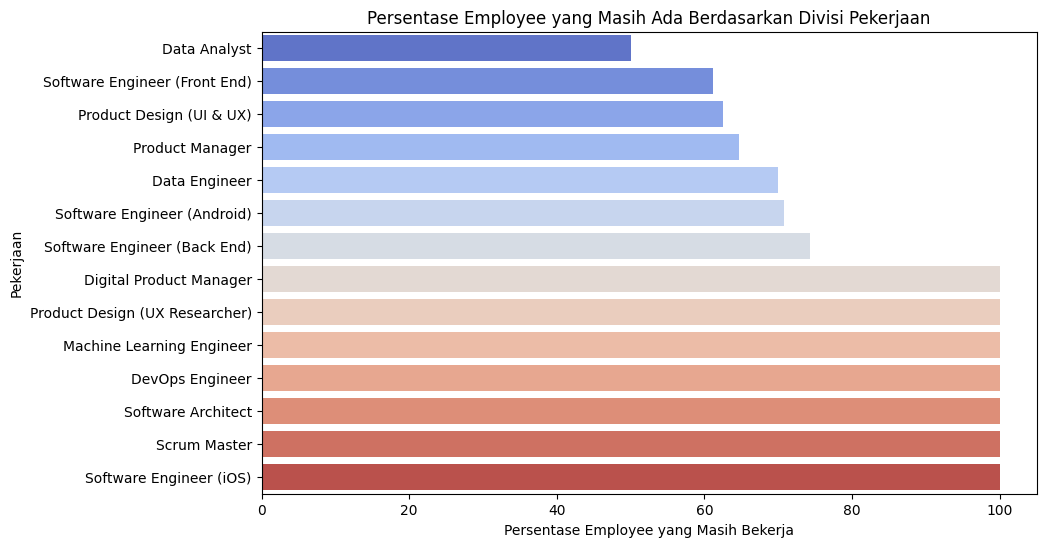

In [116]:
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_combined, x='PersentaseStay', y='Pekerjaan', palette='coolwarm')
plt.title('Persentase Employee yang Masih Ada Berdasarkan Divisi Pekerjaan')
plt.xlabel('Persentase Employee yang Masih Bekerja')
plt.ylabel('Pekerjaan')
plt.show()

## 3.5 Identify the Division with The Highest Resignation Rate

In [117]:
# Menemukan divisi dengan tingkat resign tertinggi
divisi_resign_tertinggi = agg_combined.loc[agg_combined['PersentaseStay'].idxmin(), 'Pekerjaan']

In [118]:
# Filter data employee yang resign di divisi tersebut
df_resign_divisi_tertinggi = df_resign[df_resign['Pekerjaan'] == divisi_resign_tertinggi]

In [119]:
# Mengagregasi data berdasarkan Jenjang Karir, Performa Karyawan, dan Alasan Resign
agg_divisi_resign = df_resign_divisi_tertinggi.groupby(['JenjangKarir', 'PerformancePegawai', 'AlasanResign']).size().reset_index(name='JumlahResign')

## 3.6 Visualization The Aggregation Results

In [120]:
agg_divisi_resign

,JenjangKarir,PerformancePegawai,AlasanResign,JumlahResign
0,Freshgraduate_program,Bagus,toxic_culture,1
1,Freshgraduate_program,Biasa,internal_conflict,1
2,Freshgraduate_program,Biasa,toxic_culture,1
3,Freshgraduate_program,Sangat_bagus,internal_conflict,1
4,Freshgraduate_program,Sangat_bagus,toxic_culture,3
5,Freshgraduate_program,Sangat_kurang,toxic_culture,1


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\3771619048.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




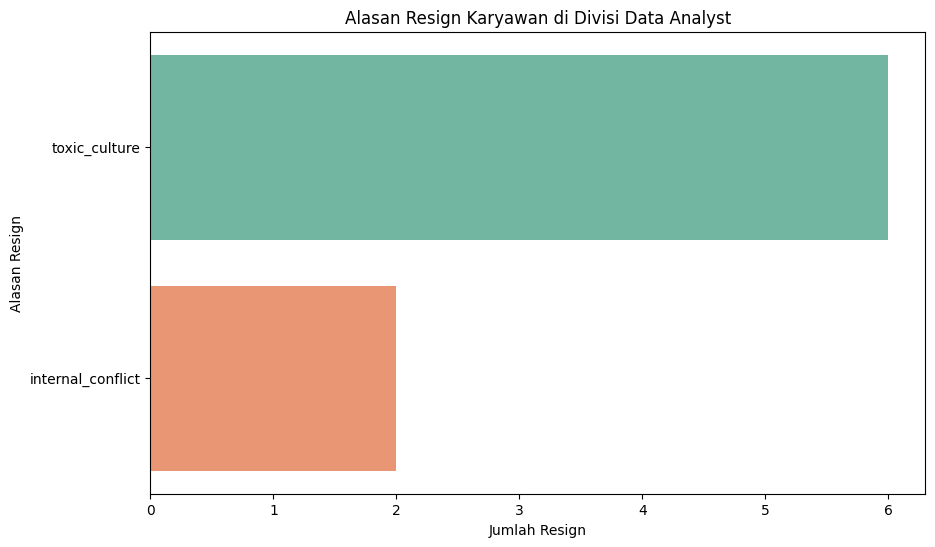

In [121]:
# Membuat plot alasan resign
plt.figure(figsize=(10, 6))
sns.countplot(data=df_resign_divisi_tertinggi, y='AlasanResign', palette='Set2')
plt.title(f'Alasan Resign Karyawan di Divisi {divisi_resign_tertinggi}')
plt.xlabel('Jumlah Resign')
plt.ylabel('Alasan Resign')
plt.show()

In [122]:
# # Membuat plot jumlah karyawan yg resign berdasarkan divisi
# plt.figure(figsize=(12, 8))
# sns.barplot(data=agg_divisi_resign, x='JumlahResign', y='JenjangKarir', hue='PerformancePegawai', palette='muted')
# plt.title(f'Jumlah Employee yang Resign Berdasarkan Jenjang Karir dan Performa Karyawan di Divisi {divisi_resign_tertinggi}')
# plt.xlabel('Jumlah Resign')
# plt.ylabel('Jenjang Karir')
# plt.legend(title='Performance Pegawai')
# plt.show()

In [123]:
# Membuat Sunburst Chart untuk visualisasi Jenjang Karir, Performance Pegawai, dan Alasan Resign
fig = px.sunburst(
    agg_divisi_resign,
    path=['JenjangKarir', 'PerformancePegawai', 'AlasanResign'],
    values='JumlahResign',
    color='JumlahResign',
    color_continuous_scale='RdYlGn',
    title=f'Sunburst Chart: Resign Berdasarkan Jenjang Karir, Performa Karyawan, dan Alasan Resign di Divisi {divisi_resign_tertinggi}'
)

# Menampilkan plot
fig.show()

Berdasarkan hasil visualisasi tersebut, insight-insight yang bisa didapatkan yaitu sebagai berikut.
- Mayoritas pegawai di divisi Data Analyst yang resign berasal dari jenjang karir Sangat Bagus dan Bagus, sedangkan yang memiliki jenjang karir Biasa juga menyumbang jumlah resign yang signifikan. Sangat Bagus mungkin adalah karyawan senior yang sudah lama bekerja dan bisa jadi ada alasan khusus mengapa mereka resign.

- Karyawan dengan performa Bagus dan Sangat Bagus justru banyak yang resign. Ini bisa menunjukkan bahwa masalahnya bukan terletak pada performa karyawan, melainkan pada faktor lain di luar kemampuan kerja.

- Toxic Culture dan Internal Conflict menjadi alasan dominan di setiap level performa, khususnya di tingkat Bagus dan Biasa. Ini menandakan bahwa lingkungan kerja yang kurang kondusif menjadi masalah besar di divisi ini.

Berdasarkan hasil visualisasi dan insight tersebut, berikut merupakan rekomendasi-rekomendasi yang dapat digunakan.
- Karena toxic culture menjadi alasan resign yang signifikan, perusahaan harus segera melakukan evaluasi mendalam mengenai budaya kerja di divisi ini. Ini bisa mencakup pelatihan bagi manajer untuk menciptakan lingkungan kerja yang lebih inklusif dan mengurangi friksi antara tim.

- Internal Conflict juga menjadi alasan utama. Ini menunjukkan adanya masalah komunikasi atau konflik interpersonal yang belum terselesaikan. Perusahaan dapat melakukan pelatihan manajemen konflik dan membentuk tim HR yang lebih aktif dalam menangani permasalahan karyawan.

- Karena banyak karyawan dengan performa Sangat Bagus dan Bagus yang resign, perusahaan perlu mempertimbangkan langkah-langkah retensi khusus seperti program loyalitas karyawan atau peningkatan reward bagi mereka yang berprestasi untuk memastikan mereka tetap bertahan di perusahaan.

- Resign dari karyawan di jenjang karir Sangat Bagus bisa jadi menandakan bahwa peluang pengembangan karir lebih lanjut kurang tersedia. Memberikan lebih banyak kesempatan promosi atau rotasi kerja bisa membantu mengurangi angka resign dari karyawan senior.

Dengan langkah-langkah tersebut, diharapkan perusahaan dapat mengurangi jumlah resign, terutama di divisi Data Analyst dan menjaga karyawan yang memiliki performa dan kontribusi tinggi.

# 4. Build an Automated Resignation Behavior Prediction

## 4.1 Data Preprocessing (Part 2)

In [124]:
df_process = df_clean.copy()

### 4.1.1 Handling Outlier

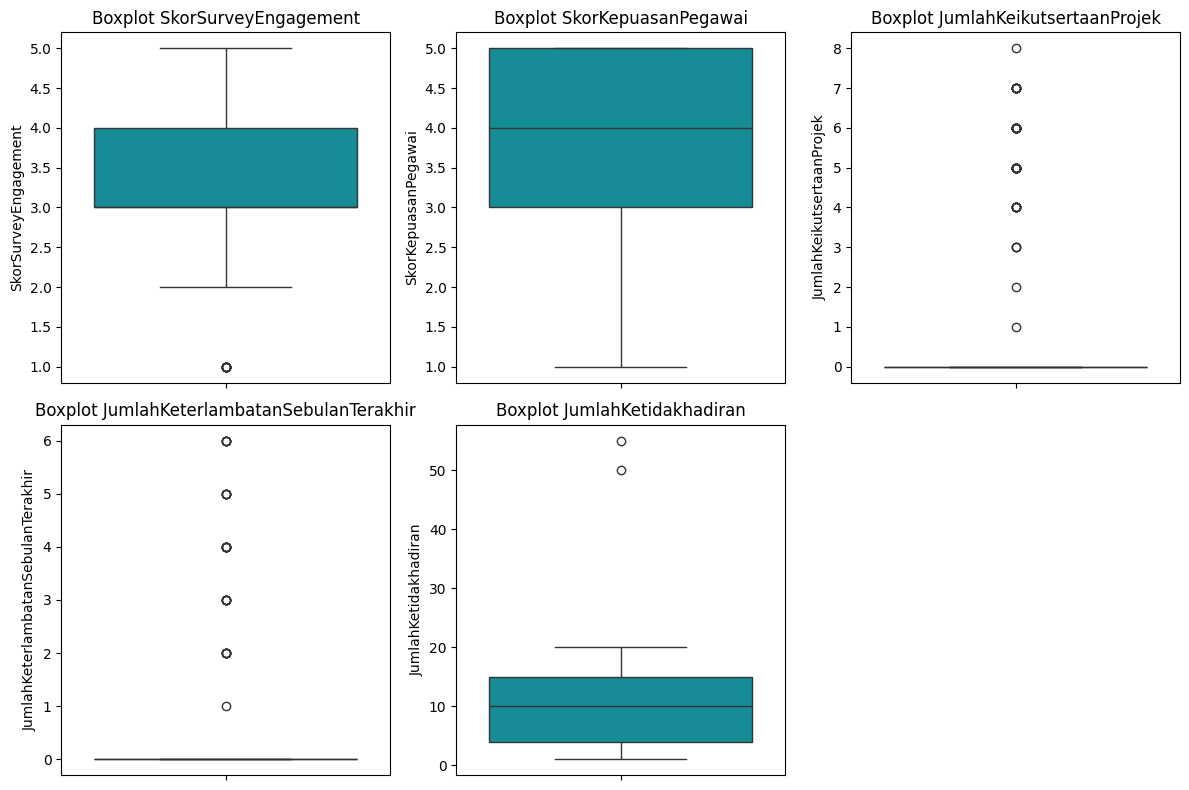

In [125]:
# Mengambil fitur numerik
numeric_features = df_process.select_dtypes(include=[np.number])

# Melakukan visualisasi box plot untuk melihat outlier
num_features = len(numeric_features.columns)
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(numeric_features.columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=column, data=df_process, color='#019fab')
    plt.title(f'Boxplot {column}')
plt.tight_layout()
plt.show()

In [126]:
# Melakukan handling outlier dengan menggantinya dengan batas maksimum
for column in numeric_features:
    # Menghitung quartiles (Q1 dan Q3)
    Q1 = df_process[column].quantile(0.25)
    Q3 = df_process[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definisikan batas outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Buat kondisi untuk mendeteksi data yang di luar batas IQR
    outliers = (df_process[column] < lower_bound) | (df_process[column] > upper_bound)

    # Jika ingin menghapus outlier
    # df_process = df_process[~outliers]

    # Jika ingin mengganti outlier dengan batas maksimum atau minimum
    # df_process[column] = np.where(df_process[column] < lower_bound, lower_bound, df_process[column])
    df_process[column] = np.where(df_process[column] > upper_bound, upper_bound, df_process[column])


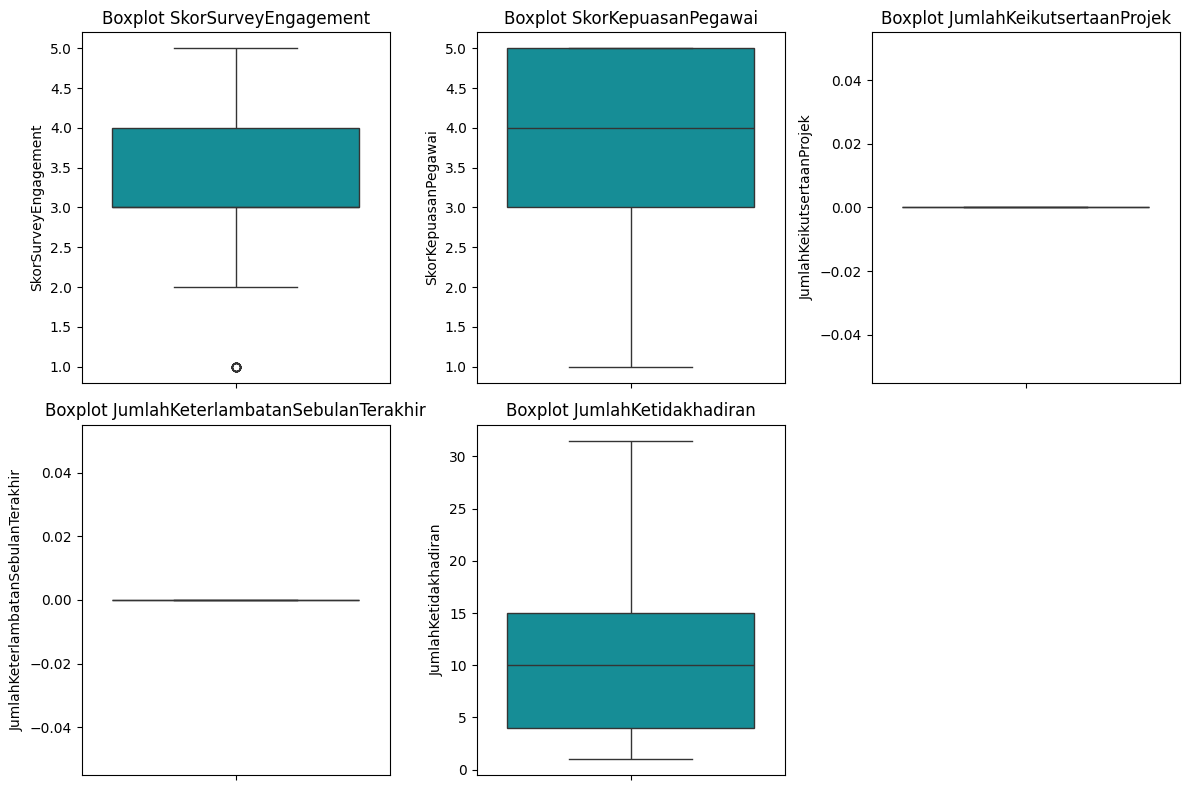

In [127]:
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(numeric_features.columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=column, data=df_process, color='#019fab')
    plt.title(f'Boxplot {column}')
plt.tight_layout()
plt.show()

- Melakukan handling outlier dengan menggantinya dengan batas maksimum.

### 4.1.2 Feature Encoding

In [128]:
categorical_features.remove('PernahBekerja')
categorical_features

['StatusPernikahan',
 'JenisKelamin',
 'StatusKepegawaian',
 'Pekerjaan',
 'JenjangKarir',
 'PerformancePegawai',
 'AsalDaerah',
 'HiringPlatform',
 'TingkatPendidikan',
 'AlasanResign']

In [129]:
df_process[categorical_features]

,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,TingkatPendidikan,AlasanResign
0,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,Magister,masih_bekerja
1,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,Sarjana,toxic_culture
2,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,Magister,jam_kerja
3,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,Sarjana,masih_bekerja
4,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,Sarjana,ganti_karir
...,...,...,...,...,...,...,...,...,...,...
282,Belum_menikah,Wanita,FullTime,Data Engineer,Mid_level,Bagus,Jakarta Pusat,Google_Search,Sarjana,masih_bekerja
283,-,Wanita,FullTime,Product Design (UI & UX),Freshgraduate_program,Biasa,Jakarta Timur,LinkedIn,Sarjana,jam_kerja
284,Menikah,Wanita,FullTime,Software Engineer (Front End),Senior_level,Biasa,Jakarta Pusat,Diversity_Job_Fair,Sarjana,ganti_karir
285,Belum_menikah,Pria,FullTime,Software Engineer (Android),Mid_level,Bagus,Jakarta Utara,Google_Search,Sarjana,kejelasan_karir


In [130]:
df_process['StatusKepegawaian'].unique()

array(['Outsource', 'FullTime', 'Internship'], dtype=object)

In [131]:
# Menggunakan LabelEncoder untuk kolom-kolom kategorikal
le = LabelEncoder()
for col in categorical_features:
    df_process[col] = le.fit_transform(df_process[col])

### 4.1.3 Feature Engineering

In [132]:
df_process.columns

Index(['StatusPernikahan', 'JenisKelamin', 'StatusKepegawaian', 'Pekerjaan',
       'JenjangKarir', 'PerformancePegawai', 'AsalDaerah', 'HiringPlatform',
       'SkorSurveyEngagement', 'SkorKepuasanPegawai',
       'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir',
       'JumlahKetidakhadiran', 'NomorHP', 'Email', 'TingkatPendidikan',
       'AlasanResign', 'TanggalLahir', 'TanggalHiring',
       'TanggalPenilaianKaryawan', 'TanggalResign'],
      dtype='object')

In [133]:
df_process[['TanggalResign','AlasanResign']]

,TanggalResign,AlasanResign
0,-,7
1,2018-6-16,10
2,2014-9-24,4
3,-,7
4,2018-09-06,2
...,...,...
282,-,7
283,2017-11-15,4
284,2018-06-08,2
285,2018-04-01,5


In [134]:
df_clean.columns

Index(['StatusPernikahan', 'JenisKelamin', 'StatusKepegawaian', 'Pekerjaan',
       'JenjangKarir', 'PerformancePegawai', 'AsalDaerah', 'HiringPlatform',
       'SkorSurveyEngagement', 'SkorKepuasanPegawai',
       'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir',
       'JumlahKetidakhadiran', 'NomorHP', 'Email', 'TingkatPendidikan',
       'AlasanResign', 'TanggalLahir', 'TanggalHiring',
       'TanggalPenilaianKaryawan', 'TanggalResign'],
      dtype='object')

In [135]:
# Membuat fitur baru seperti LamaBekerja dan Resign
df_process['LamaBekerja'] = (pd.to_datetime(df_process['TanggalPenilaianKaryawan']) - pd.to_datetime(df_process['TanggalHiring'])).dt.days // 365   # Lama bekerja
df_process['Resign'] = df_process['TanggalResign'].apply(lambda x: 1 if x != '-' else 0)            # Apakah sudah resign atau belum

### 4.1.4 Feature Selection

In [136]:
# Pilih fitur yang penting untuk domain knowledge
selected_features = ['Pekerjaan', 'JenjangKarir', 'PerformancePegawai', 'LamaBekerja', 'JumlahKeikutsertaanProjek', 
                     'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'SkorKepuasanPegawai', 'StatusPernikahan']

In [137]:
# Seperate feature and target
x = df_process[selected_features]
y = df_process['Resign']  # Target variable (1 and 0)

### 4.1.5 Standardization

In [138]:
numerical_cols = ['LamaBekerja', 'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'SkorKepuasanPegawai']

In [139]:
# Scaling numerical features
scaler = StandardScaler()
x[numerical_cols] = scaler.fit_transform(x[numerical_cols])

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_12468\3776948686.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 4.2 Data Split & Data Imbalanced

### 4.2.1 Data Split

In [140]:
# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 4.2.2 Handling Data Imbalanced

Data Label Distribution:
Resign
0    198
1     89
Name: count, dtype: int64


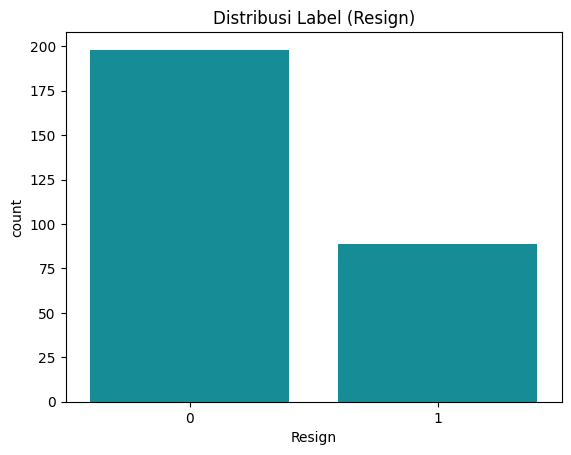

In [141]:
# Pengecekan distribusi label
print("Data Label Distribution:")
print(df_process['Resign'].value_counts())
sns.countplot(x='Resign', data=df_process, color='#019fab')
plt.title('Distribusi Label (Resign)')
plt.show()

In [142]:
# Imbalanced Learning using SMOTE
sm = SMOTE(random_state=42)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

## 4.3 Modeling

In [143]:
# Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

In [144]:
# Function untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Logistic Regression Accuracy: 0.4827586206896552


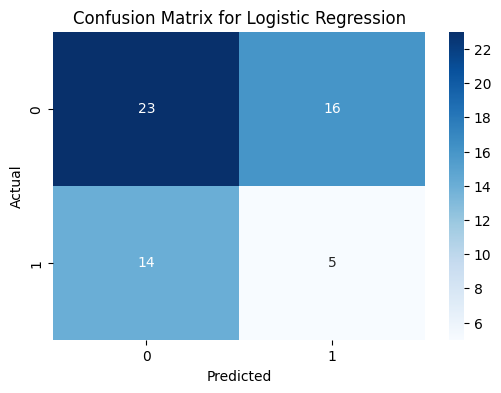

Random Forest Accuracy: 0.6379310344827587


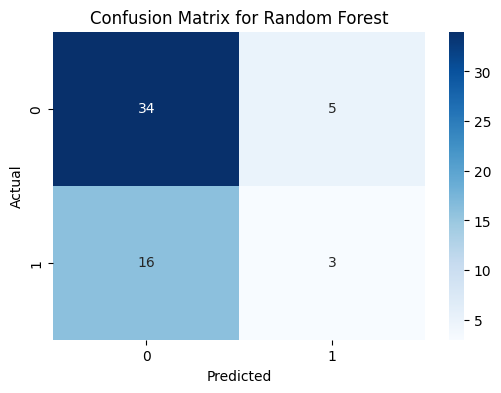

Decision Tree Accuracy: 0.5172413793103449


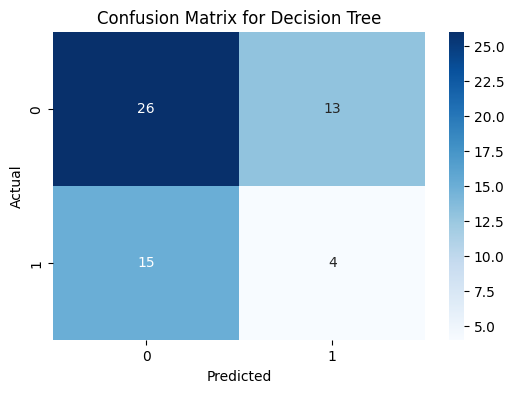

K-Nearest Neighbors Accuracy: 0.5172413793103449


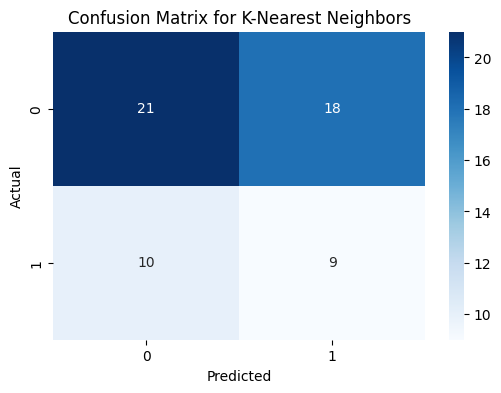

In [145]:
# Training dan evaluasi setiap model
model_results = {}
df_metrics = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
# df_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
metrics_list = []
for model_name, model in models.items():
    model.fit(x_train_smote, y_train_smote)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    model_results[model_name] = acc
    print(f"{model_name} Accuracy: {acc}")
    # print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix for {model_name}')
    
    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Simpan hasil evaluasi ke DataFrame
    metrics_list.append([model_name, accuracy, precision, recall, f1])

df_metrics = pd.DataFrame(metrics_list, columns=df_metrics)

In [146]:
# Tampilkan hasil evaluasi
df_metrics

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.482759,0.238095,0.263158,0.250000
1,Random Forest,0.637931,0.375000,0.157895,0.222222
2,Decision Tree,0.517241,0.235294,0.210526,0.222222
3,K-Nearest Neighbors,0.517241,0.333333,0.473684,0.391304


## 4.4 Hyperparameter Tuning

In [147]:
best_model_name = 'Random Forest'
best_model = models[best_model_name]

In [148]:
# Hyperparameter tuning for RandomForest (as an example)
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [20, 30, None],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 4, 6]
}

In [149]:
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train_smote, y_train_smote)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, None],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [5, 7, 10],
                         'n_estimators': [200, 300, 500]},
             verbose=2)

## 4.5 Evaluation

In [150]:
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(x_test)

print(f"Best {best_model_name} Accuracy\t: {accuracy_score(y_test, y_pred_rf)}")
print(f"Best {best_model_name} Precision\t: {precision_score(y_test, y_pred_rf)}")
print(f"Best {best_model_name} Recall\t: {recall_score(y_test, y_pred_rf)}")
print(f"Best {best_model_name} F1 Score\t: {f1_score(y_test, y_pred_rf)}")

Best Random Forest Accuracy	: 0.6551724137931034
Best Random Forest Precision	: 0.4444444444444444
Best Random Forest Recall	: 0.21052631578947367
Best Random Forest F1 Score	: 0.2857142857142857


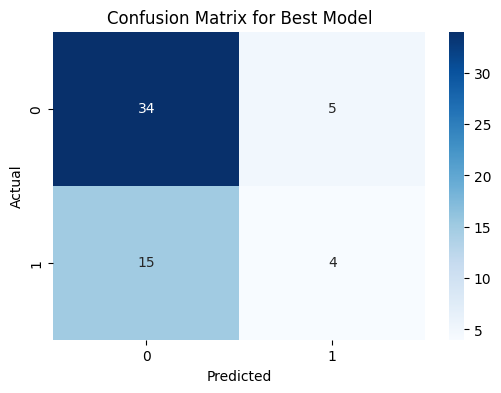

In [151]:
# Confusion Matrix
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix for Best Model')

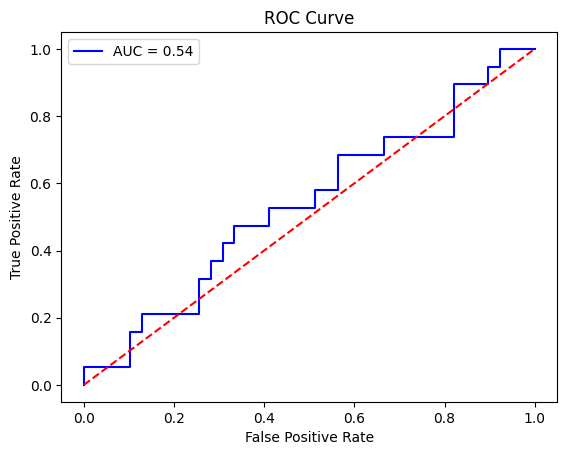

In [152]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_rf.predict_proba(x_test)[:, 1])
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, best_rf.predict_proba(x_test)[:, 1]):.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

- Berdasarkan hasil evaluasi model ini cukup baik dalam melakukan prediksi karyawan yang tidak resign, tetapi lemah dalam mendeteksi karyawan yang resign.

# 5. Business Recommendation

## 5.1 Feature Importance

In [153]:
# Mendapatkan feature importance dari model
importances = best_rf.feature_importances_
features = x_train_smote.columns  # Kolom fitur yang digunakan dalam training

# Membuat DataFrame dari hasil feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

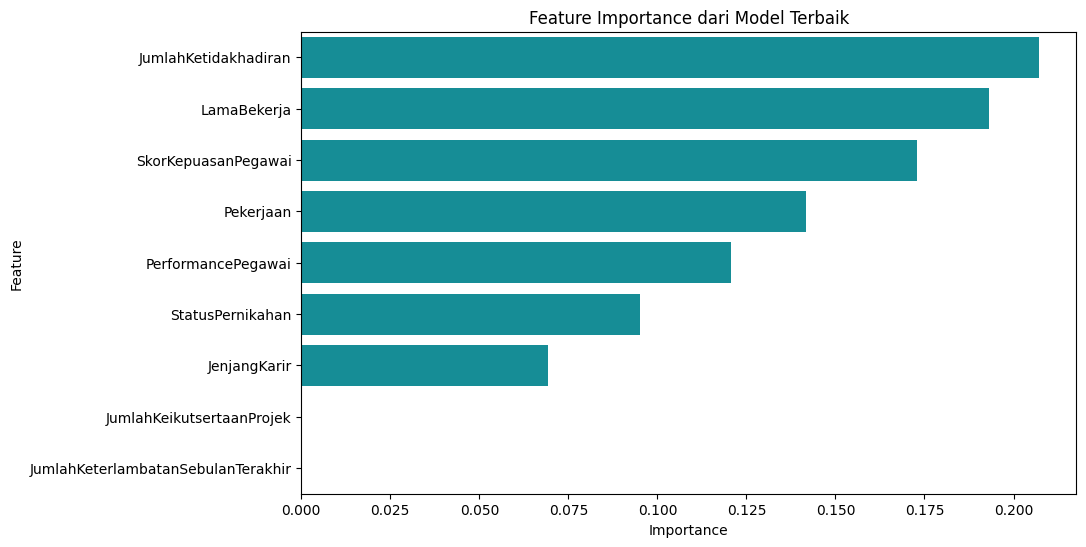

In [154]:
# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='#019fab')
plt.title('Feature Importance dari Model Terbaik')
plt.show()

Berdasarkan grafik dari feature importance tersebut, insight-insight berikut.
- Fitur JumlahKetidakhadiran adalah yang paling signifikan dalam mempengaruhi prediksi resign. Tingginya ketidakhadiran karyawan menunjukkan adanya disengagement atau potensi masalah kesejahteraan.

- Semakin lama karyawan bekerja, semakin tinggi risiko mereka untuk resign. Hal ini bisa berkaitan dengan kejenuhan atau kurangnya peluang pengembangan karir.

- Tingkat kepuasan karyawan secara langsung memengaruhi keputusan untuk bertahan atau resign. Karyawan yang merasa kurang puas lebih mungkin untuk meninggalkan perusahaan.

- Pekerjaan atau peran karyawan di perusahaan juga memengaruhi risiko resign. Posisi tertentu mungkin memiliki beban kerja atau tekanan yang lebih tinggi.

- Karyawan dengan kinerja yang baik mungkin merasa undervalued jika tidak diberikan penghargaan yang setimpal.

## 5.2 Recommendation

Berdasarkan insight-insight yang didapat, berikut business recommendation yang dapat diberikan.
- Tingkatkan Program Kesejahteraan Karyawan, perusahaan perlu fokus pada pengurangan jumlah ketidakhadiran dengan menawarkan program kesehatan mental, sesi konseling, dan fleksibilitas kerja.

- Pengembangan Karir yang Jelas, perusahaan sebaiknya menyediakan jalur karir yang transparan, peluang promosi, dan rotasi pekerjaan untuk karyawan yang telah lama bekerja untuk menjaga motivasi dan menghindari kejenuhan.

- Monitoring dan Peningkatan Kepuasan Kerja, perusahaan perlu melakukan survei kepuasan karyawan secara rutin dan tindak lanjuti hasilnya dengan perbaikan lingkungan kerja serta kebijakan yang mendukung keseimbangan kerja-hidup.

- Evaluasi Beban Kerja dan Dukungan di Setiap Pekerjaan, perusahaan perlu melakukan analisis beban kerja di setiap posisi untuk memastikan tidak ada karyawan yang merasa terbebani secara berlebihan. Tambahkan dukungan atau sumber daya sesuai kebutuhan.

- Penghargaan untuk Karyawan Berkinerja Tinggi, perusahaan perlu mengimplementasikan program penghargaan dan pengakuan bagi karyawan yang menunjukkan kinerja baik untuk menjaga motivasi dan keterikatan mereka dengan perusahaan.